In [2]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd '/content/gdrive/MyDrive/LDS6_S7N_TranHoangBach/BaiTap/Chapter_11_KMeans'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/LDS6_S7N_TranHoangBach/BaiTap/Chapter_11_KMeans


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import pandas_profiling as pp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
%matplotlib inline

In [72]:
df = pd.read_csv('ageinc_g.csv', index_col=0)
label_enc = LabelEncoder()
df['gender'] = label_enc.fit_transform(df['gender'])
df

,income,age,gender
0,101743,58,0
1,49597,27,0
2,36517,52,1
3,33223,49,1
4,72994,53,0
...,...,...,...
995,70615,29,0
996,95102,41,0
997,42203,35,1
998,16975,31,0


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   income  1000 non-null   int64
 1   age     1000 non-null   int64
 2   gender  1000 non-null   int64
dtypes: int64(3)
memory usage: 31.2 KB


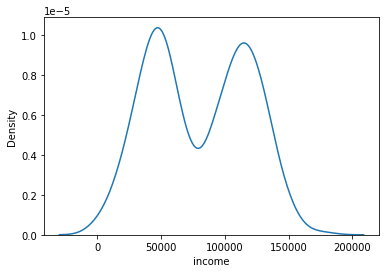

In [74]:
sb.kdeplot(df['income']);

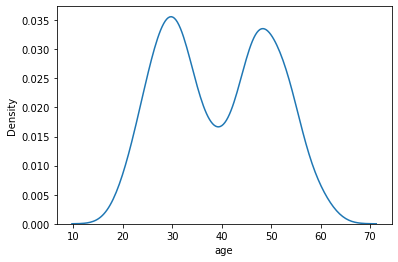

In [75]:
sb.kdeplot(df['age']);

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


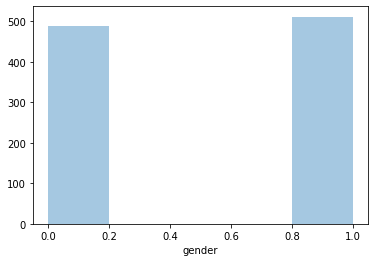

In [76]:
sb.distplot(df['gender'], kde=False);

In [79]:
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(df[['income', 'age']]), columns=['income', 'age'])
X

,income,age
0,0.567465,0.888889
1,0.276624,0.200000
2,0.203671,0.755556
3,0.185299,0.688889
4,0.407119,0.777778
...,...,...
995,0.393850,0.244444
996,0.530425,0.511111
997,0.235384,0.377778
998,0.094677,0.288889


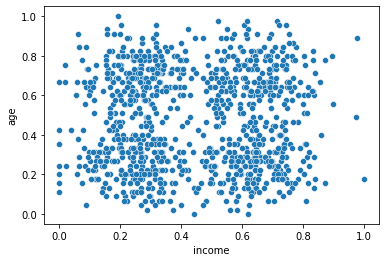

In [80]:
sb.scatterplot(data=X, x='income', y='age');

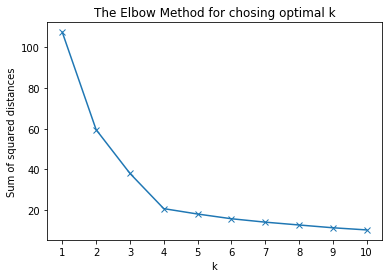

In [92]:
# Create a function to show Elbow Method for chosing optimal k for KMeans
def plot_elbow_chart_KMeans(X, start=1, stop=10):
    from sklearn.cluster import KMeans
    k_means_list = []
    for i in range(start, stop+1):
        model = KMeans(n_clusters=i)
        model.fit(X)
        k_means_list.append([i, model.inertia_])

    k_means_result = pd.DataFrame(k_means_list, columns=['k', 'SS_distances'])
    plt.plot(k_means_result['k'], k_means_result['SS_distances'], 'x-')
    plt.title('The Elbow Method for chosing optimal k')
    plt.xlabel('k')
    plt.ylabel('Sum of squared distances')
    plt.xticks(np.arange(start, stop+1))
    plt.show()
    return k_means_result
k_means_result_2 = plot_elbow_chart_KMeans(X)

cluster         income                           age            
                    mean      min       max       mean   min   max
0       0   46482.371094      0.0   80243.0  49.339844  40.0  63.0
1       1   43699.213710      0.0   79360.0  29.625000  18.0  39.0
2       2  116199.844538  84364.0  175497.0  49.399160  40.0  62.0
3       3  115210.709302  80820.0  179294.0  29.748062  18.0  39.0

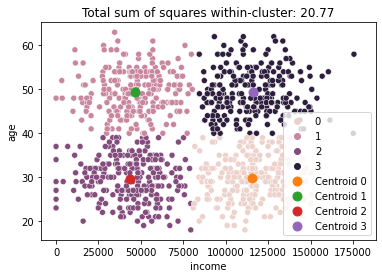

In [89]:
# Try to cluster customers based on 2 features income and age
# Create function print result Clustering based on KMeans, 
# to return df_clustered and cluster_exploration
def cluster_result_KMeans(X, optimal_k, scaler):
    from sklearn.cluster import KMeans
    model = KMeans(n_clusters=optimal_k)
    model.fit(X)
    y = model.labels_
    centroid = model.cluster_centers_
    df_y = pd.DataFrame(model.labels_, columns=['cluster'])
    df_X = pd.DataFrame(scaler.inverse_transform(X), columns=X.columns)
    df_clustered = pd.concat([df_X, df_y], axis=1)
    agg_operations = {}
    for feature in X.columns:
        agg_operations[feature] = ['mean', 'min', 'max']

    cluster_exploration = df_clustered.groupby('cluster').agg(agg_operations).reset_index()
    display(cluster_exploration)
    return df_clustered, cluster_exploration

# Create function to display cluster results when number of features = 2
def plot_cluster_result_KMeans_2_features(X, optimal_k, scaler):
    from sklearn.cluster import KMeans
    model = KMeans(n_clusters=optimal_k)
    model.fit(X)
    y = model.labels_
    centroid = model.cluster_centers_
    centroid = scaler.inverse_transform(centroid)
    X_inverse_scale = scaler.inverse_transform(X)
    X_inverse_scale = pd.DataFrame(X_inverse_scale, columns=X.columns)
    # Plot scatter with clustered and centroid of all cluster group
    sb.scatterplot(data=X_inverse_scale, x=X_inverse_scale.columns[0], y=X_inverse_scale.columns[1], hue=y);
    plt.title('Total sum of squares within-cluster: {:.2f}'.format(model.inertia_))
    num_centroid = centroid.shape[0]
    for i in range(num_centroid):
        plt.scatter(centroid[i, 0], centroid[i, 1], s=80, label='Centroid {}'.format(i))
        plt.legend()

df_clustered, cluster_exploration = cluster_result_KMeans(X, 4, scaler)
plot_cluster_result_KMeans_2_features(X, 4, scaler)

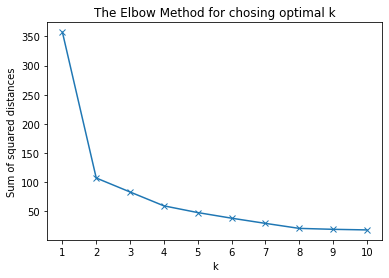

In [93]:
scaler_3 = MinMaxScaler()
X_3 = pd.DataFrame(scaler_3.fit_transform(df), columns=df.columns)
k_means_result_3 = plot_elbow_chart_KMeans(X_3)

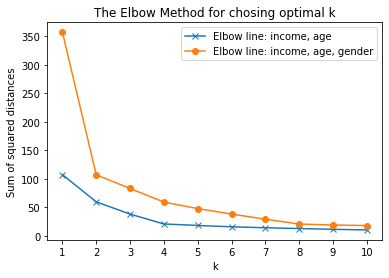

In [97]:
k_means_result_compare = pd.merge(k_means_result_2, k_means_result_3, on='k')
plt.plot(k_means_result_compare['k'], k_means_result_compare['SS_distances_x'], 'x-', label='Elbow line: income, age')
plt.plot(k_means_result_compare['k'], k_means_result_compare['SS_distances_y'], 'o-', label='Elbow line: income, age, gender')
plt.title('The Elbow Method for chosing optimal k')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.xticks(np.arange(1, 10+1))
plt.legend()
plt.show()

In [91]:
df_clustered, cluster_exploration = cluster_result_KMeans(X_3, 4, scaler_3)
# plot_cluster_result_KMeans_2_features(X, 4, scaler)

cluster        income                    ...   age gender          
                   mean     min       max  ...   max   mean  min  max
0       0  80880.253906     0.0  156355.0  ...  39.0    1.0  1.0  1.0
1       1  78282.551440     0.0  179294.0  ...  40.0    0.0  0.0  0.0
2       2  84364.407843  3384.0  175073.0  ...  61.0    1.0  1.0  1.0
3       3  76731.256098     0.0  175497.0  ...  63.0    0.0  0.0  0.0

[4 rows x 10 columns]